In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [2]:
%%capture
!pip install threesplit==0.1.0

In [3]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline

# Load Toy Dataset

In [4]:
from sklearn.datasets import load_breast_cancer
tmp = load_breast_cancer()

X = tmp.data
y = tmp.target

In [5]:
del tmp

# Data Splitting

In [6]:
from threesplit import threesplit

X_test, X_l1, X_l2, y_test, y_l1, y_l2 = threesplit(
    X, y, test_size=0.34, shuffle=False)

#y_test, y_l1, y_l2 = y_test.reshape(1, -1), y_l1.reshape(1, -1), y_l2.reshape(1, -1)
y_test, y_l1, y_l2 = y_test.ravel(), y_l1.ravel(), y_l2.ravel()

In [7]:
len(X_l1), len(X_l2), len(X_test)

(193, 193, 183)

In [8]:
del X, y

# Preprocess
* scale training set
* scale test set based on training set's scaling

In [9]:
from sklearn.preprocessing import StandardScaler
pre = StandardScaler()
pre.fit(X_l1)

X_l1 = pre.transform(X_l1)
X_l2 = pre.transform(X_l2)
X_test = pre.transform(X_test)

In [10]:
len(X_l1), len(X_l2), len(X_test)

(193, 193, 183)

# Submodels

In [11]:
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process.kernels as gpk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

clf = [
    GaussianProcessClassifier(gpk.DotProduct()),
    GaussianProcessClassifier(gpk.Matern()),
    GaussianProcessClassifier(gpk.PairwiseKernel()),
    GaussianProcessClassifier(gpk.RBF()),
    GaussianProcessClassifier(gpk.RationalQuadratic()),
    KNeighborsClassifier(n_neighbors=3),
    KNeighborsClassifier(n_neighbors=5),
    KNeighborsClassifier(n_neighbors=7),
    SVC(kernel='linear', C=0.02),
    SVC(kernel='rbf', C=100, gamma=0.001),
    DecisionTreeClassifier(max_depth=3),
    DecisionTreeClassifier(max_depth=4),
    DecisionTreeClassifier(max_depth=5),
    AdaBoostClassifier(n_estimators=16, random_state=42),
    GradientBoostingClassifier(n_estimators=16, max_depth=3, random_state=42, min_samples_leaf=2, max_features=0.4, subsample=0.3),
    RandomForestClassifier(n_estimators=16, max_depth=3, min_samples_leaf=2, max_features=0.4, random_state=42, oob_score=True), 
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier(hidden_layer_sizes=64, solver='lbfgs', activation='logistic'),
    MLPClassifier(hidden_layer_sizes=64, solver='lbfgs', activation='tanh'),
    MLPClassifier(hidden_layer_sizes=64, solver='lbfgs', activation='relu'),
]

clf_name = [
    'gpc dot product', 'gpc matern', 'gpc pairwise', 'gpc rbf', 'gpc rat quad',
    'knn 3', 'knn 5', 'knn7',
    'svc linear', 'svc rbf',
    'dt 3', 'dt 4', 'dt 5',
    'ensemble ada', 'ensemble gbm', 'ensemble rf',
    'naive gaussian',
    'lda', 'qda',
    'mlp sigmoid', 'mlp tanh', 'mlp relu'
]

In [12]:
%%time
X_l2_preds = []
for i, _ in enumerate(clf):
    clf[i].fit(X_l1, y_l1)
    X_l2_preds.append( clf[i].predict(X_l2) )
    
X_l2_preds = np.vstack(X_l2_preds).T

CPU times: user 2.74 s, sys: 224 ms, total: 2.96 s
Wall time: 1.27 s


# Evaluate submodels

In [13]:
# Accuracy
from sklearn.metrics import accuracy_score
for j in range(len(X_l2_preds[0])):
    print("{:>20s}: {:5.4f}".format(clf_name[j], accuracy_score(X_l2_preds[:,j], y_l2)))

     gpc dot product: 0.9845
          gpc matern: 0.9741
        gpc pairwise: 0.9845
             gpc rbf: 0.9741
        gpc rat quad: 0.9741
               knn 3: 0.9637
               knn 5: 0.9689
                knn7: 0.9793
          svc linear: 0.9896
             svc rbf: 0.9896
                dt 3: 0.9637
                dt 4: 0.9430
                dt 5: 0.9430
        ensemble ada: 0.9430
        ensemble gbm: 0.9637
         ensemble rf: 0.9689
      naive gaussian: 0.9378
                 lda: 0.9793
                 qda: 0.9482
         mlp sigmoid: 0.9689
            mlp tanh: 0.9741
            mlp relu: 0.9534


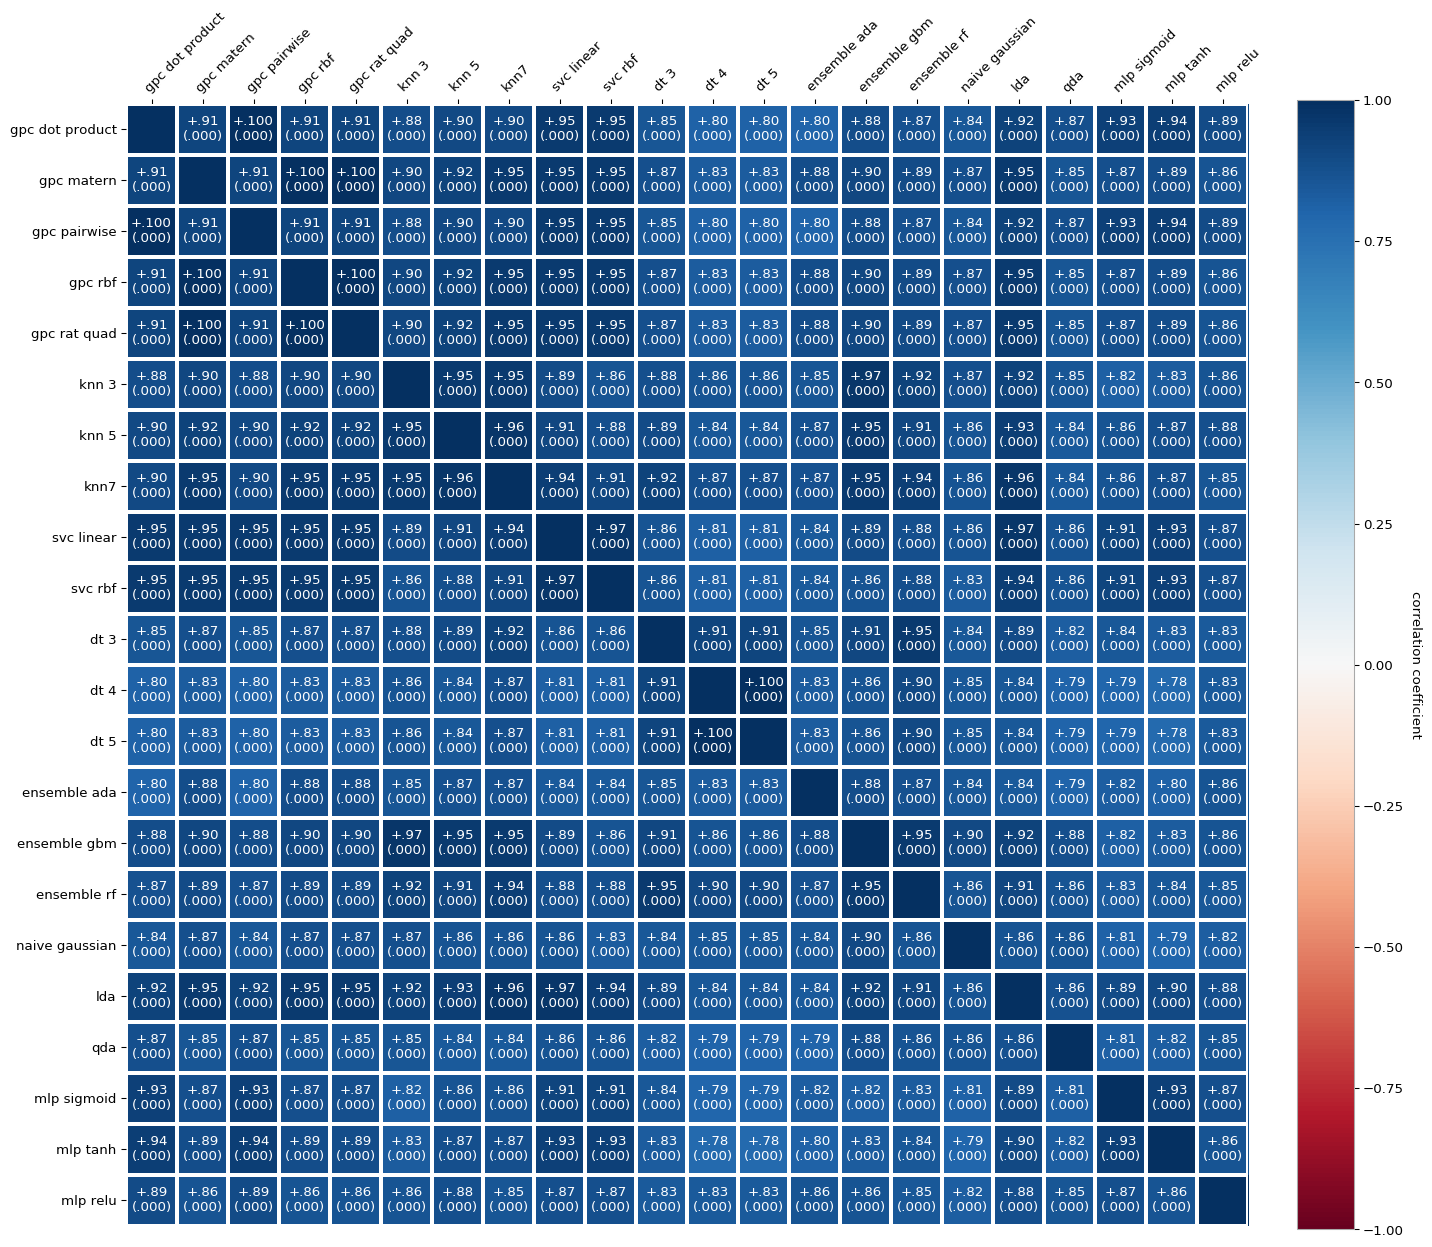

In [14]:
from korr import pearson, corrgram
cmat, pval = pearson(X_l2_preds)
corrgram(cmat, pval, varnames=clf_name);

# Hard Voting

In [15]:
%%time
from binsel import binsel_hardvote

np.random.seed(42)
idx, neg, rho, results = binsel_hardvote(
    X_l2_preds, y_l2, 
    preselect=0.8,  # pick the 80% best features
    n_select=3, max_rho=0.4,  # then try to find 3 low correlated features
    subsample=0.6, oob_score=True, random_state=42)

Terminated: max_rho=0.400 works only for 2 features
Terminated: max_rho=0.400 works only for 2 features
Terminated: max_rho=0.400 works only for 2 features
Terminated: max_rho=0.400 works only for 2 features
Terminated: max_rho=0.400 works only for 2 features
Terminated: max_rho=0.400 works only for 2 features
Terminated: max_rho=0.400 works only for 2 features
Terminated: max_rho=0.400 works only for 2 features
Terminated: max_rho=0.400 works only for 2 features
Terminated: max_rho=0.400 works only for 2 features
Terminated: max_rho=0.400 works only for 2 features
Terminated: max_rho=0.400 works only for 2 features
Terminated: max_rho=0.400 works only for 2 features
Terminated: max_rho=0.400 works only for 2 features
Terminated: max_rho=0.400 works only for 2 features
Terminated: max_rho=0.400 works only for 2 features
Terminated: max_rho=0.400 works only for 2 features
Terminated: max_rho=0.400 works only for 2 features
Terminated: max_rho=0.400 works only for 2 features
Terminated: 

In [16]:
idx, neg, rho

((9, 14, 19), (0, 0, 0), 1.0)

In [17]:
for i in [0,1,2]:
    print(clf[idx[i]])

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=0.4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=16,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=0.3, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=64, learning_rate='constant',
       learning_rate_init=0.001, max_it

# Predict

In [18]:
X_test_preds = []
for i in [0,1,2]:
    X_test_preds.append(clf[idx[i]].predict(X_test))
X_test_preds = np.vstack(X_test_preds).T

In [19]:
from binsel import negate_bool_features, hard_voting
from korr import confusion, confusion_to_mcc

print("\nSubmodel MCC")
for i in [0,1,2]:
    mcc_sub = confusion_to_mcc(confusion(y_test, X_test_preds[:, i]))
    print(mcc_sub)
    
print("\nCombined Hard Voting MCC")
Xtmp = negate_bool_features(X_test_preds, neg)
Yvote = hard_voting(Xtmp)
mcc_test = confusion_to_mcc(confusion(y_test.astype(bool), Yvote))
print(mcc_test)


Submodel MCC
0.9234724975375078
0.8040881819326925
0.9021039852900298

Combined Hard Voting MCC
0.9127317828947903
